In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import functools 
import datetime

import pmana.utils

In [2]:
TIME_DIR = "20251124"
TIME_RANGE = "20251124_20251127"

#### Parse raw CAEN DT5781 data

In [3]:
PATH_INPUT  = f"/Users/triozzi/Downloads/Test_{TIME_DIR}_DT5781_Compass/DAQ/run/RAW"
PATH_TARGET = f"../data/{TIME_DIR}/DataPadova_DT5781_CSV_{TIME_RANGE}"

pmana.utils.io.FormatDT5781RawData(
    PATH_INPUT,  ###< raw Padova test-stand campaign
    PATH_TARGET  ###< target path for the restructured data
)

df_ch0 = pmana.utils.io.PandasizeDT5781RawData(PATH_TARGET + f"/CH0")
df_ch1 = pmana.utils.io.PandasizeDT5781RawData(PATH_TARGET + f"/CH1")
df_ch3 = pmana.utils.io.PandasizeDT5781RawData(PATH_TARGET + f"/CH3")

Saved merged DataFrame to: ../data/20251124/DataPadova_DT5781_CSV_20251124_20251127/CH0/CH0.pkl
Saved merged DataFrame to: ../data/20251124/DataPadova_DT5781_CSV_20251124_20251127/CH1/CH1.pkl
Saved merged DataFrame to: ../data/20251124/DataPadova_DT5781_CSV_20251124_20251127/CH3/CH3.pkl


#### Analyze a campaign

In [4]:
# filter data accounting for negative test pulse 
# this is messing up everything, so you'll need
# to account for this by hand :)
# also, 'flags' is a keyword
df_ch0 = df_ch0[df_ch0['flags'] == 0]
df_ch1 = df_ch1[df_ch1['flags'] == 0]
df_ch3 = df_ch3[df_ch3['energy'] > 0]

In [5]:
def SimpleAnalysis(
    df,
    AGGREGATOR = 'time_bin_10min'
):
  
  group = df.groupby(AGGREGATOR)
  means = group.mean()
  stds  = group.std()

  t = means['time']
  mean = means['energy']
  std = stds['energy']
  
  return t, mean, std

In [6]:
t_CH0, Peak_CH0, Err_Peak_CH0 = SimpleAnalysis(df_ch0)
t_CH1, Peak_CH1, Err_Peak_CH1 = SimpleAnalysis(df_ch1)
t_CH3, Peak_CH3, Err_Peak_CH3 = SimpleAnalysis(df_ch3)

#### Compare with oscilloscope-based setup

In [7]:
CH1 = pandas.read_csv(f'../out/{TIME_RANGE}_Complete_CH1.txt', delimiter=' ')
CH1['Date'] = pandas.to_datetime(CH1['Date'], format="%Y-%m-%d %H:%M:%S")

CH2 = pandas.read_csv(f'../out/{TIME_RANGE}_Complete_CH2.txt', delimiter=' ')
CH2['Date'] = pandas.to_datetime(CH2['Date'], format="%Y-%m-%d %H:%M:%S")

CH3 = pandas.read_csv(f'../out/{TIME_RANGE}_Complete_CH3.txt', delimiter=' ')
CH3['Date'] = pandas.to_datetime(CH3['Date'], format="%Y-%m-%d %H:%M:%S")

In [8]:
# convert date to seconds
CH1['DateFrom'] = (CH1['Date'] - CH1['Date'].iloc[0]).dt.total_seconds()
CH2['DateFrom'] = (CH2['Date'] - CH2['Date'].iloc[0]).dt.total_seconds()
CH3['DateFrom'] = (CH3['Date'] - CH3['Date'].iloc[0]).dt.total_seconds()

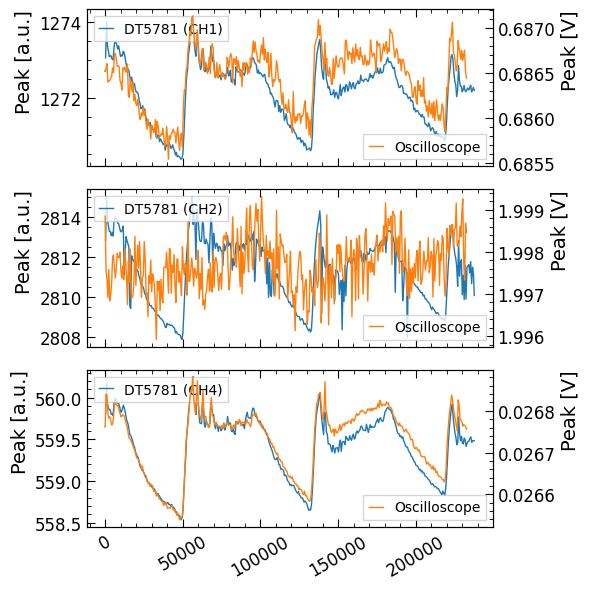

In [9]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
pmana.utils.plotting.PlotTimeSeries(ax[0], t_CH0, Peak_CH0, LABEL='DT5781 (CH1)', XLABELS=False)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Peak [a.u.]')

# CH1
pmana.utils.plotting.PlotTimeSeries(ax[1], t_CH1, Peak_CH1, LABEL='DT5781 (CH2)', XLABELS=False)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [a.u.]')

# CH1
pmana.utils.plotting.PlotTimeSeries(ax[2], t_CH3, Peak_CH3, LABEL='DT5781 (CH4)')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'Peak [a.u.]')

'''
# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1.5, label='DT5781 (CH1)')
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Peak [a.u.]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1.5, label='DT5781 (CH2)')
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [a.u.]')
ax[1].set_xticklabels([])

# CH3
ax[2].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1.5, label='DT5781 (CH4)')
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'Peak [a.u.]')
# ax[2].set_xticklabels([])
'''

for a, ch in zip(ax, [CH1, CH2, CH3]):
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    # a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.plot(ch.DateFrom, ch.Peak, lw=1., c='C1', label='Oscilloscope')
    # a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Peak [V]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')

plt.show()
fig.savefig(f"../plots/DT5781_RawBased_Oscilloscope_{TIME_RANGE}.png", dpi=300, bbox_inches='tight')